# Gaze Interception
This notebook takes in two files taken from the Pupil Recordings you have exported in Pupil Player. These are:
- `gaze_positions.csv` (contains raw data in regards to the gaze made throughout the recording)
- `info.player.json` (contains system and sync time used to format the recording timestamps)

In [21]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
# File Paths
info_player_filePath = 'source/info.player.json'
gaze_csv_filePath = 'source/gaze_positions.csv'
annotations_filepath = 'source/annotations.csv'

In [22]:
# Helper Functions
def calculate_angular_distance(x, y):
    """
    Calculate angular distance given Cartesian coordinates (x, y).
    
    Parameters:
        x (array-like): X-coordinates.
        y (array-like): Y-coordinates.
        
    Returns:
        array: Angular distances.
    """
    return np.arctan2(y, x)

def calculate_velocity(angular_distance, timestamp):
    """
    Calculate velocity given angular distance and corresponding timestamps.
    
    Parameters:
        angular_distance (array-like): Angular distances.
        timestamp (array-like): Timestamps.
        
    Returns:
        array: Calculated velocity.
    """
    time_diff = np.diff(timestamp)
    angular_distance_diff = np.diff(angular_distance)
    velocity = angular_distance_diff / time_diff
    return np.concatenate(([np.nan], velocity))

def generate_random_color():
    """
    Generate a random RGB color tuple.
    
    Returns:
        tuple: Random RGB color.
    """
    return (random.random(), random.random(), random.random())

def draw_object_line(ax, timestamp, label, object_colors):
    """
    Draw a vertical line on the given axis to represent an object and add a text label.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axis to draw on.
        timestamp (float): Timestamp for the vertical line.
        label (str): Label for the object.
        object_colors (dict): Dictionary to store object colors.
    """
    object_number = label.split(' ')[-1]

    if object_number not in object_colors:
        object_colors[object_number] = generate_random_color()

    ax.axvline(x=timestamp, color=object_colors[object_number], linestyle='--', alpha=0.7)
    ax.text(timestamp, ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2, 
            f'{label} {object_number} at: {timestamp:.2f}', rotation=90, verticalalignment='center', horizontalalignment='right', color=object_colors[object_number], alpha=0.7)

def draw_objects_and_interceptions(fig, ax, spawn_timestamps, interception_timestamps, object_colors, annotations_df):
    """
    Draw lines and labels representing spawned objects and interceptions on the given axis.
    
    Parameters:
        fig: The figure.
        ax: The axis to draw on.
        spawn_timestamps (array-like): Timestamps for spawned objects.
        interception_timestamps (array-like): Timestamps for interceptions.
        object_colors (dict): Dictionary to store object colors.
        annotations_df: DataFrame containing annotations.
    """
    for timestamp, label in zip(spawn_timestamps, annotations_df.loc[annotations_df['label'].str.startswith('Spawned'), 'label']):
        draw_object_line(ax, timestamp, label, object_colors)

        object_number = label.split(' ')[-1]
        corresponding_interception = annotations_df.loc[(annotations_df['label'].str.startswith('Intercepted')) & (annotations_df['label'].str.endswith(object_number)), 'timestamp'].values
        if len(corresponding_interception) > 0:
            ax.axvline(x=corresponding_interception[0], color=object_colors[object_number], linestyle='--', alpha=0.7)

    for timestamp, label in zip(interception_timestamps, annotations_df.loc[annotations_df['label'].str.startswith('Intercepted'), 'label']):
        draw_object_line(ax, timestamp, label, object_colors)

def draw_experiment_lines(ax, start_timestamp, end_timestamp):
    """
    Draw vertical lines on the given axis to represent the start and end of an experiment.
    
    Parameters:
        ax: The axis to draw on.
        start_timestamp (float): Timestamp for the start of the experiment.
        end_timestamp (float): Timestamp for the end of the experiment.
    """
    ax.axvline(x=start_timestamp, color='black', linestyle='--')
    ax.axvline(x=end_timestamp, color='black', linestyle='--')
    ax.set_xlim(start_timestamp, end_timestamp)



Reading the `info.player` JSON to retrieve `start_time_synced_s` and `start_time_system_s`. This is used to format the timestamp correctly to indicate time throughout the experiment:

In [23]:
with open(info_player_filePath, 'r') as file:
    data = json.load(file)

start_time_synced_s = data.get('start_time_synced_s')
start_time_system_s = data.get('start_time_system_s')

offset = start_time_system_s - start_time_synced_s
print(f"Offset between system and synced start time: {offset}")

Offset between system and synced start time: 1708616105.5367994


Reading the `gaze_position.csv`, reformatting the timestamps into seconds starting at 0:

In [24]:
gaze_df = pd.read_csv(gaze_csv_filePath)
print(f"There is a total of {len(gaze_df)} in the Gaze DataFrame")

# Converting timestamps into time (starting from 0)
def convert_timestamps_to_time(df, timestamp_column, offset):
    df['time'] = df[timestamp_column] + offset
    df['time'] -= df['time'].min()
    return df

gaze_df = convert_timestamps_to_time(gaze_df, 'gaze_timestamp', offset)
print(gaze_df['time'])

There is a total of 3799 in the Gaze DataFrame
0        0.000000
1        0.004102
2        0.008056
3        0.011957
4        0.015991
          ...    
3794    17.010016
3795    17.012243
3796    17.016012
3797    17.020298
3798    17.024242
Name: time, Length: 3799, dtype: float64


Smoothing `norm_pos_x` and `norm_pos_y` and plotting on a Position x Time graph:

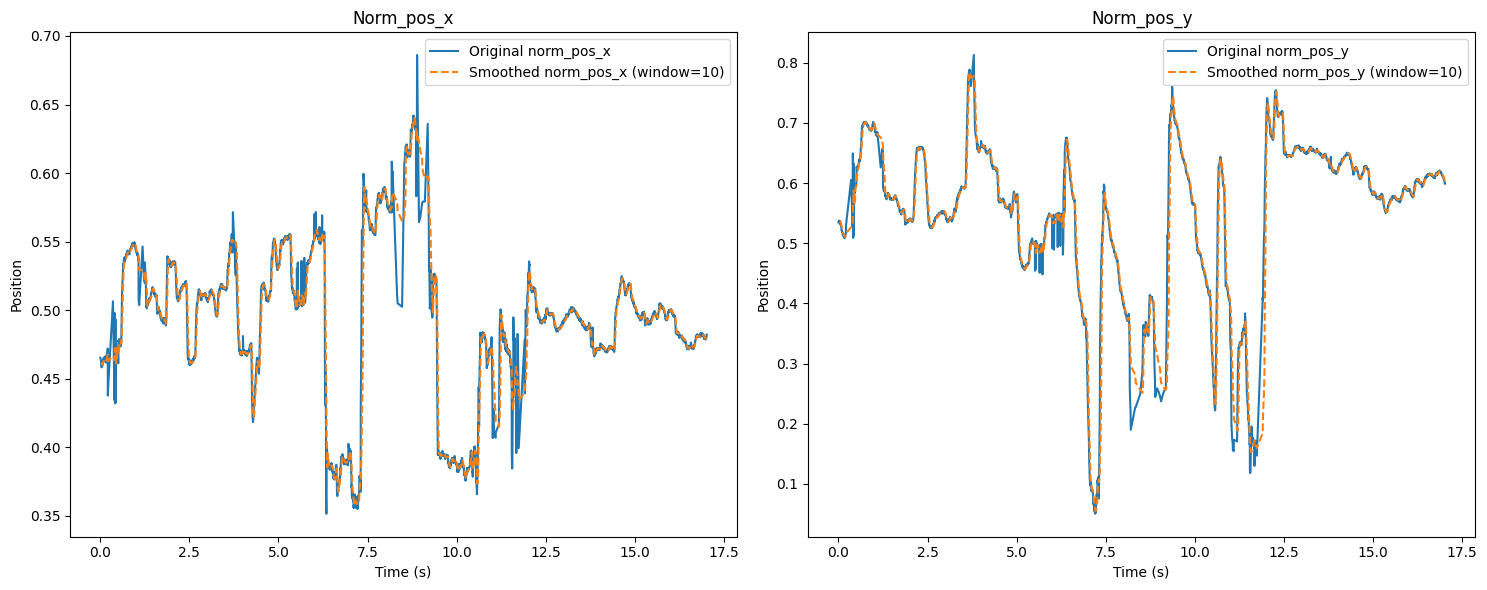

In [25]:
window_size = 10
gaze_df['smoothed_norm_pos_x'] = gaze_df['norm_pos_x'].rolling(window=window_size).mean()
gaze_df['smoothed_norm_pos_y'] = gaze_df['norm_pos_y'].rolling(window=window_size).mean()

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(gaze_df['time'], gaze_df['norm_pos_x'], label='Original norm_pos_x')
axs[0].plot(gaze_df['time'], gaze_df['smoothed_norm_pos_x'], label=f'Smoothed norm_pos_x (window={window_size})', linestyle='--')
axs[0].set_title('Norm_pos_x')

axs[1].plot(gaze_df['time'], gaze_df['norm_pos_y'], label='Original norm_pos_y')
axs[1].plot(gaze_df['time'], gaze_df['smoothed_norm_pos_y'], label=f'Smoothed norm_pos_y (window={window_size})', linestyle='--')
axs[1].set_title('Norm_pos_y')

for ax in axs:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position')
    ax.legend()

plt.tight_layout()
plt.show()

# Plotting Angular Distance agaisnt Time

Calculating `angular_distance` of using normalised `x` and `y` (both smoothed and unsmoothed): 

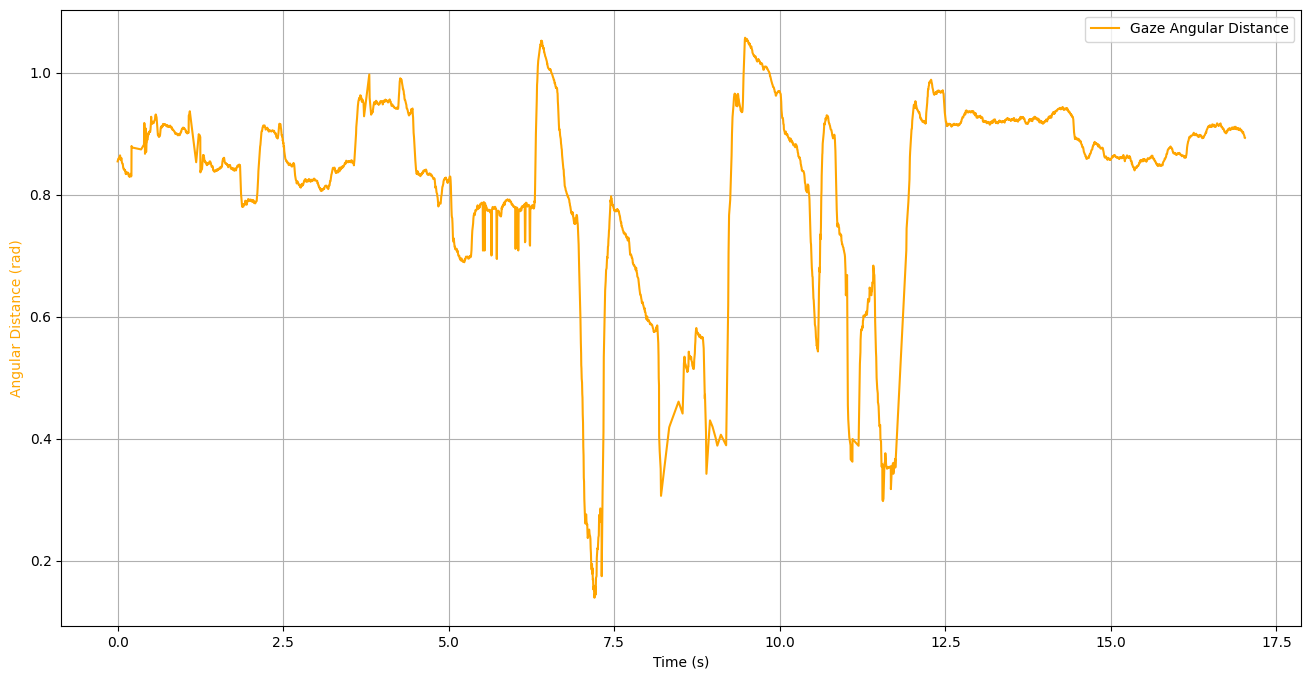

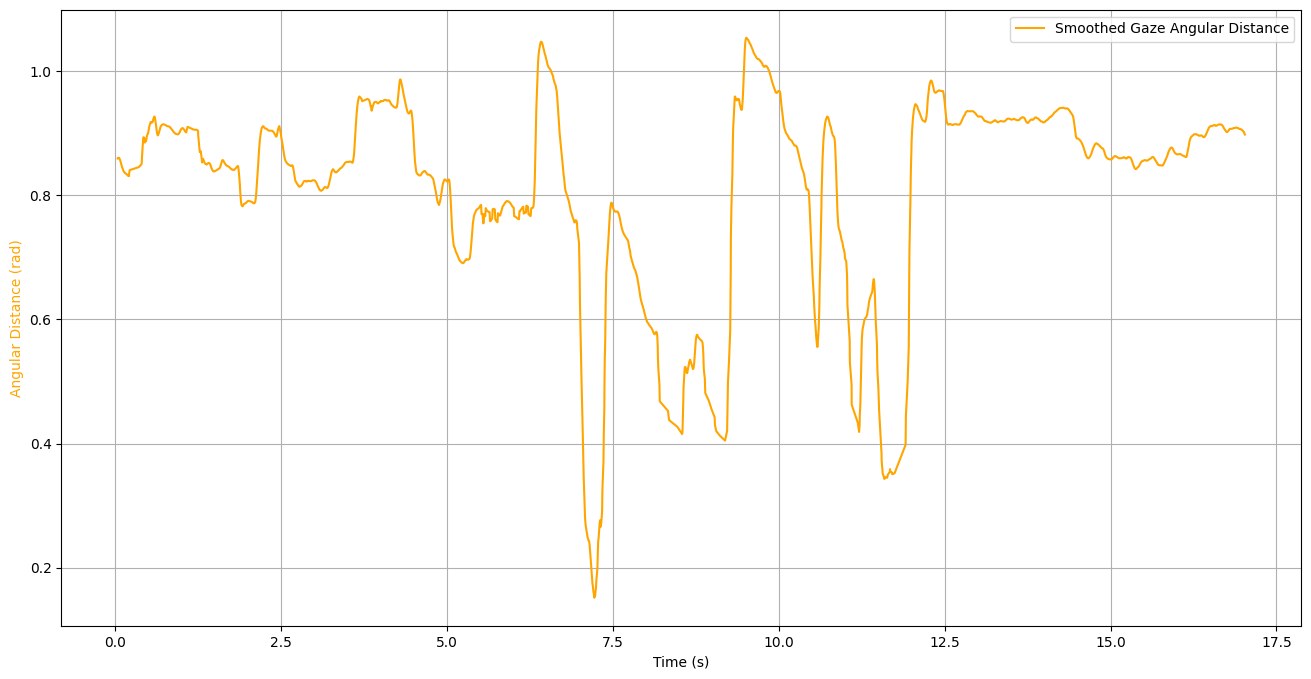

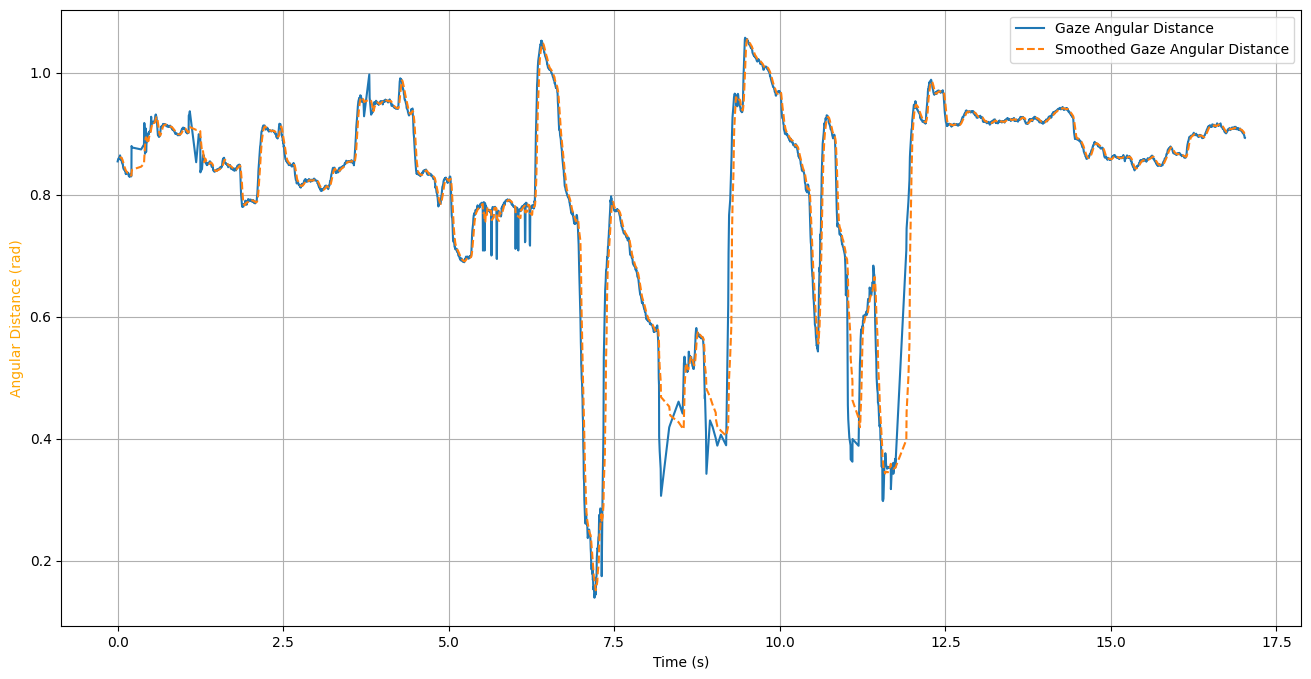

In [26]:
gaze_df['angular_distance'] = calculate_angular_distance(gaze_df['norm_pos_x'], gaze_df['norm_pos_y'])
gaze_df['smoothed_angular_distance'] = calculate_angular_distance(gaze_df['smoothed_norm_pos_x'], gaze_df['smoothed_norm_pos_y'])

# Defining a graph to work with throughout the script:
figure, ax = plt.subplots(figsize=(16, 8))
smoothed_figure, ax2 = plt.subplots(figsize=(16, 8))

def plot_angular_graph(figure, ax, df, source='angular_distance', show_both=False):
    """
    Plot angular distance data from a DataFrame against time.

    Parameters:
        df: DataFrame containing angular distance data.
        source (str): Source of angular distance data ('angular_distance' or 'smoothed_angular_distance').
        show_both (bool): Whether to show both raw and smoothed angular distance on the same plot.
    """

    if show_both:
        ax.plot(df['time'], df['angular_distance'], label='Gaze Angular Distance',)
        ax.plot(df['time'], df['smoothed_angular_distance'], label=f'Smoothed Gaze Angular Distance', linestyle='--')
    
    else:
        if source == 'smoothed_angular_distance':
            ax.plot(df['time'], df['smoothed_angular_distance'], label=f'Smoothed Gaze Angular Distance', color='orange')
        else:
            ax.plot(df['time'], df['angular_distance'], label='Gaze Angular Distance', color='orange')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Angular Distance (rad)', color='orange')

    ax.legend()
    ax.grid(True)

    fig.suptitle('Interception Experiment')

plot_angular_graph(figure, ax, gaze_df)
plot_angular_graph(smoothed_figure, ax2, gaze_df, source='smoothed_angular_distance')

combined_figure, ax3 = plt.subplots(figsize=(16, 8))
plot_angular_graph(combined_figure, ax3, gaze_df, show_both=True)


# Identifying Saccadic Movements
Based on the research from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1190820/pdf/jphysiol00502-0164.pdf, Saccadic Movements have a stereotypical velocity graph where large peaks indicates a fast movement between two points (saccades). These are almost like straight lines between points.

Calculating the gradient (velocity) at each point of the graph:

We create a new column in the `gaze_df` dataframe where it calculates the angular velocity using the `time` and `angular_distance` between each point

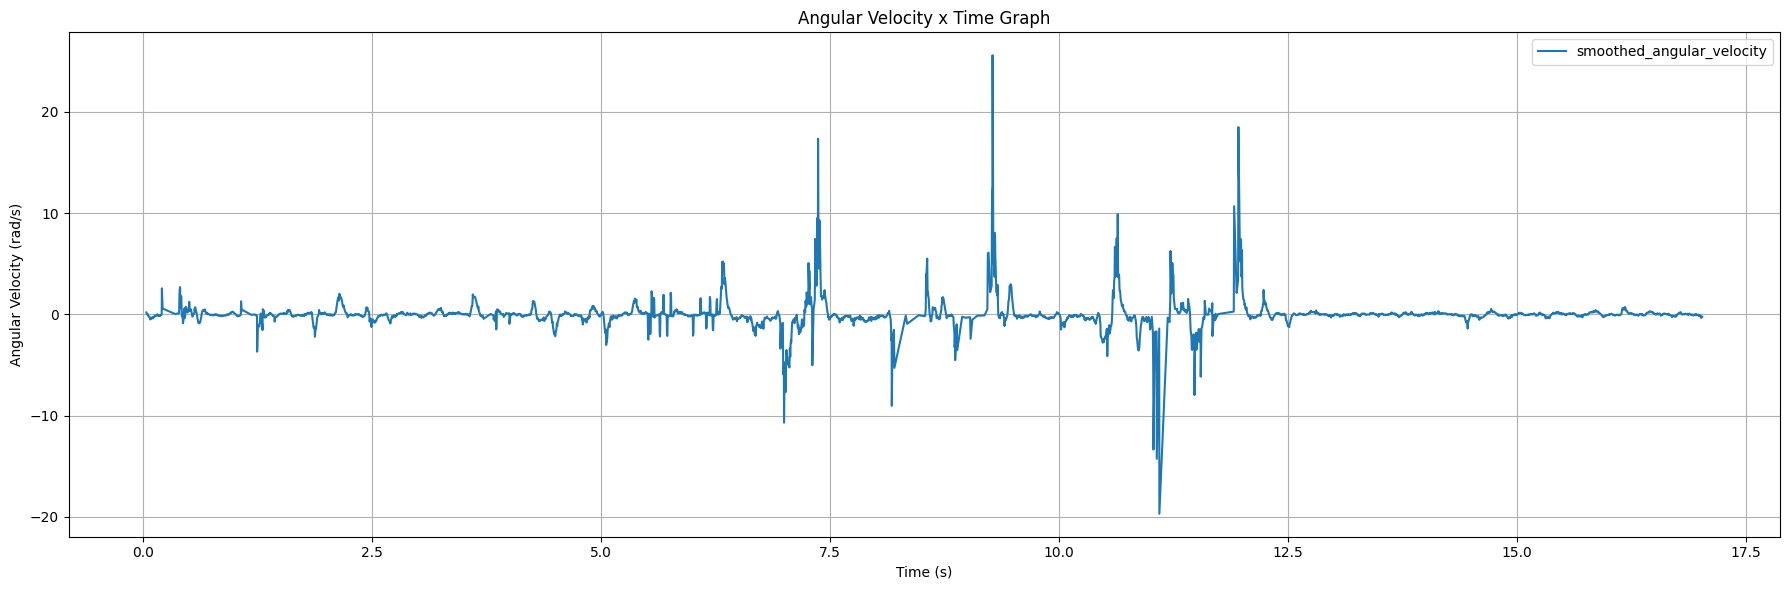

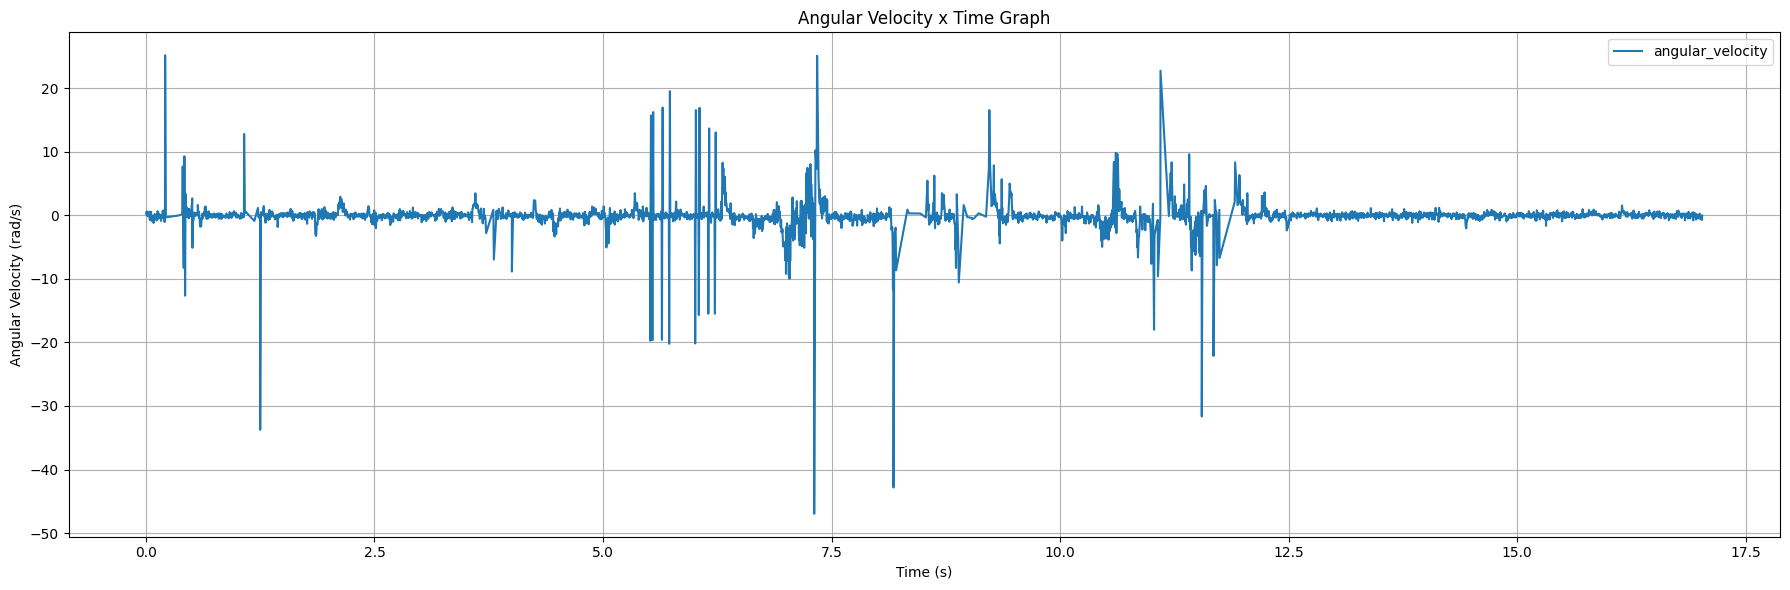

In [27]:
gaze_df['angular_velocity'] = calculate_velocity(gaze_df['angular_distance'], gaze_df['time'])
gaze_df['smoothed_angular_velocity'] = calculate_velocity(gaze_df['smoothed_angular_distance'], gaze_df['time'])

def plot_velocity_graph(df, source='angular_velocity'):
    """
    Plot angular velocity data from a DataFrame against time.

    Parameters:
        df: DataFrame containing angular velocity data.
        source (str): Source of angular velocity data ('angular_velocity' by default).

    """

    plt.figure(figsize=(18, 6))
    plt.plot(df['time'], df[source], label=f'{source}',)

    plt.title('Angular Velocity x Time Graph')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (rad/s)')
    # plt.ylabel('Gaze Position')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plot_velocity_graph(gaze_df, 'smoothed_angular_velocity')
plot_velocity_graph(gaze_df)

Identifying regions of high velocity (when a velocity at a point exceeds a threshold) and plot saccadic movements on the Angular Distance Time Graph:

`plot_saccade_graph` takes a column from the DataFrame (`angular_velocity` or `smoothed_angular_velocity`) and plots it agaisnt time.
The parameter `show_velocity` allows to display the velocity graph (same as above) under the main graph

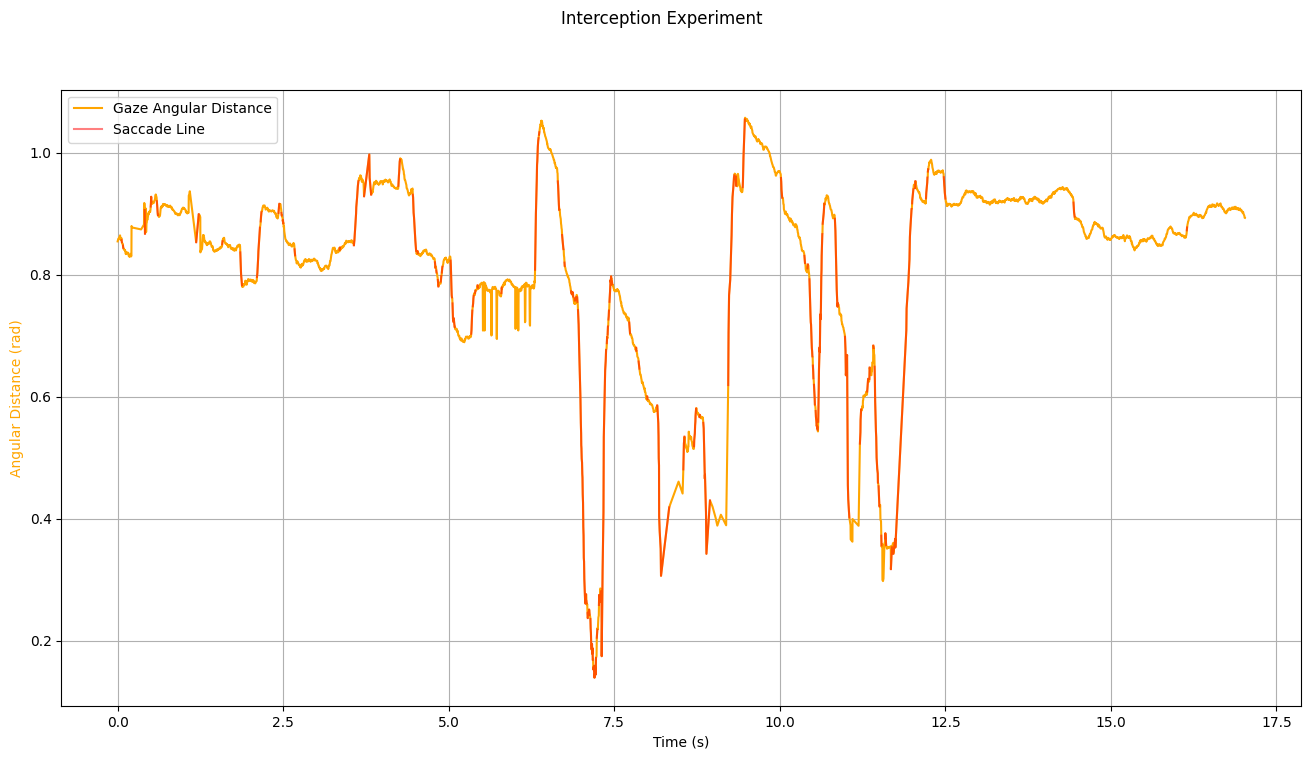

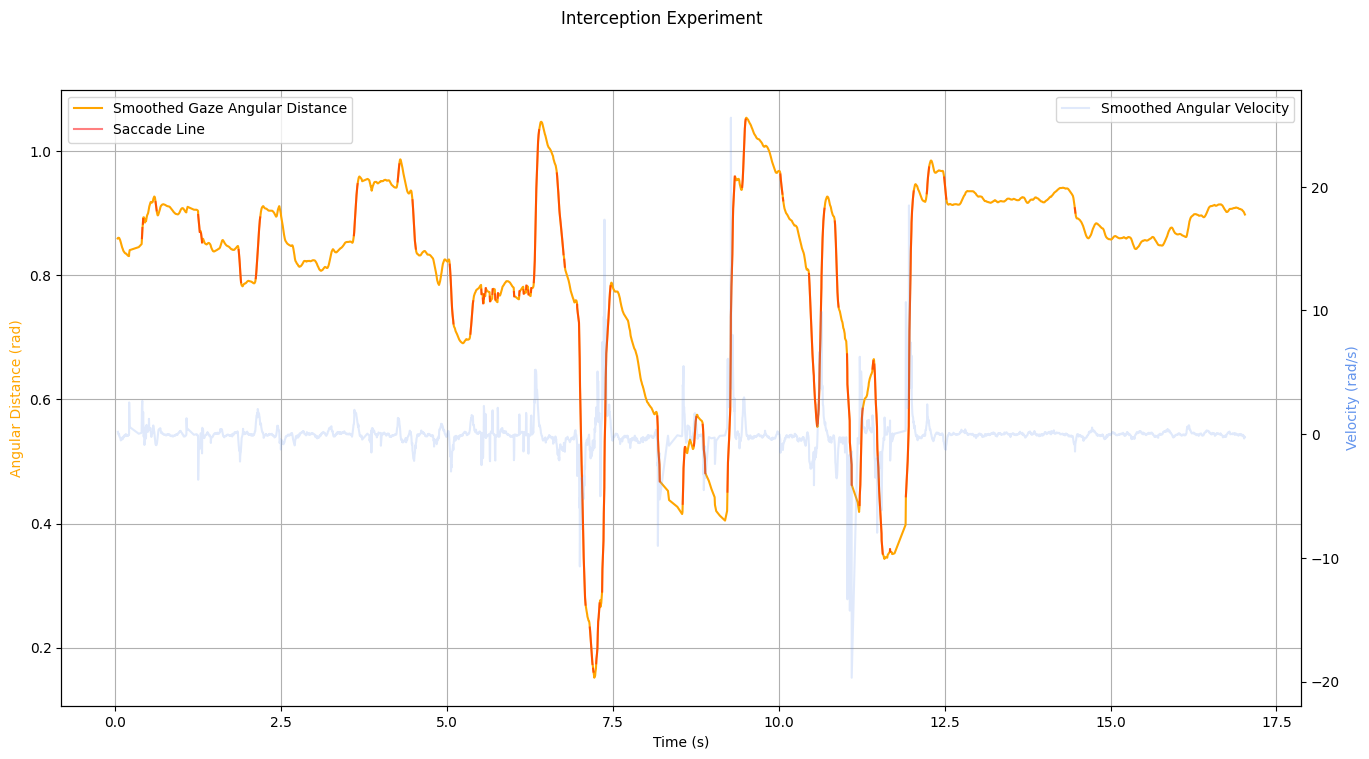

In [28]:
def plot_saccade_graph(fig, ax, df, source='angular_velocity', threshold_velocity=0.8, show_velocity=False):
    """
    Plot saccade-related data from a DataFrame agaisnt time. And optionally show the velocity graph under.

    Parameters:
        fig : The Figure object to plot on.
        ax : The primary Axes object to plot on.
        df : DataFrame containing saccade-related data.
        source (str): Source of data ('angular_velocity' or 'smoothed_angular_velocity' by default).
        threshold_velocity (float): Threshold for identifying saccades based on velocity.
        show_velocity (bool): Whether to show velocity data on the plot.
    """
    velocity_label = "Angular Velocity"
    source_angular = gaze_df['angular_distance']
    source_velocity = gaze_df['angular_velocity']

    saccade_regions_high = df[source] > threshold_velocity
    accade_regions_low = df[source] < -threshold_velocity
    saccade_regions = saccade_regions_high | accade_regions_low


    if (source == 'smoothed_angular_velocity'):
        source_angular = gaze_df['smoothed_angular_distance']
        source_velocity = gaze_df['smoothed_angular_velocity']
        velocity_label = "Smoothed Angular Velocity"
        angular_label = "Smoothed Angular Distance"
    else:
        source_angular = gaze_df['angular_distance']
        source_velocity = gaze_df['angular_velocity']

    
    # Plot for Unsmoothed Data
    ax.plot(gaze_df['time'], np.where(saccade_regions, source_angular, np.nan), color='red', label='Saccade Line', alpha=0.5)
    ax.legend(loc='upper left')

    if show_velocity:
        ax1_2 = ax.twinx()
        ax1_2.plot(gaze_df['time'], source_velocity, label=f'{velocity_label}', linestyle='-', color='cornflowerblue', alpha=0.2)
        ax1_2.set_ylabel('Velocity (rad/s)', color='cornflowerblue')
        ax1_2.legend(loc='upper right')

    # Set common title
    fig.suptitle('Interception Experiment')
    ax.grid(True)

vel_ang_fig, ax = plt.subplots(figsize=(16, 8))
plot_angular_graph(vel_ang_fig, ax, gaze_df)
plot_saccade_graph(vel_ang_fig, ax, gaze_df)

vel_ang_fig_smoothed, ax1_2 = plt.subplots(figsize=(16, 8))
plot_angular_graph(vel_ang_fig_smoothed, ax1_2, gaze_df, source='smoothed_angular_distance')
plot_saccade_graph(vel_ang_fig_smoothed, ax1_2, gaze_df, source='smoothed_angular_velocity', show_velocity=True)


# Identifying Smooth Pursuit
Smooth pursuit occurs when the eyes tracks an moving object at a constant speed. There is roughly a constant velocity as the angular distance changes slowly, whereas Saccades are almost instant. We choose regions of the line where the change in velocity is under a threshold, and the change of angular distance is small enough to indicate the eyes moving between positions slowly.

`plot_smooth_pursuit_graph` takes a column from the DataFrame (`angular_velocity` or `smoothed_angular_velocity`) and plots it agaisnt time.
The parameter `show_velocity` allows to display the velocity graph (same as above) under the main graph

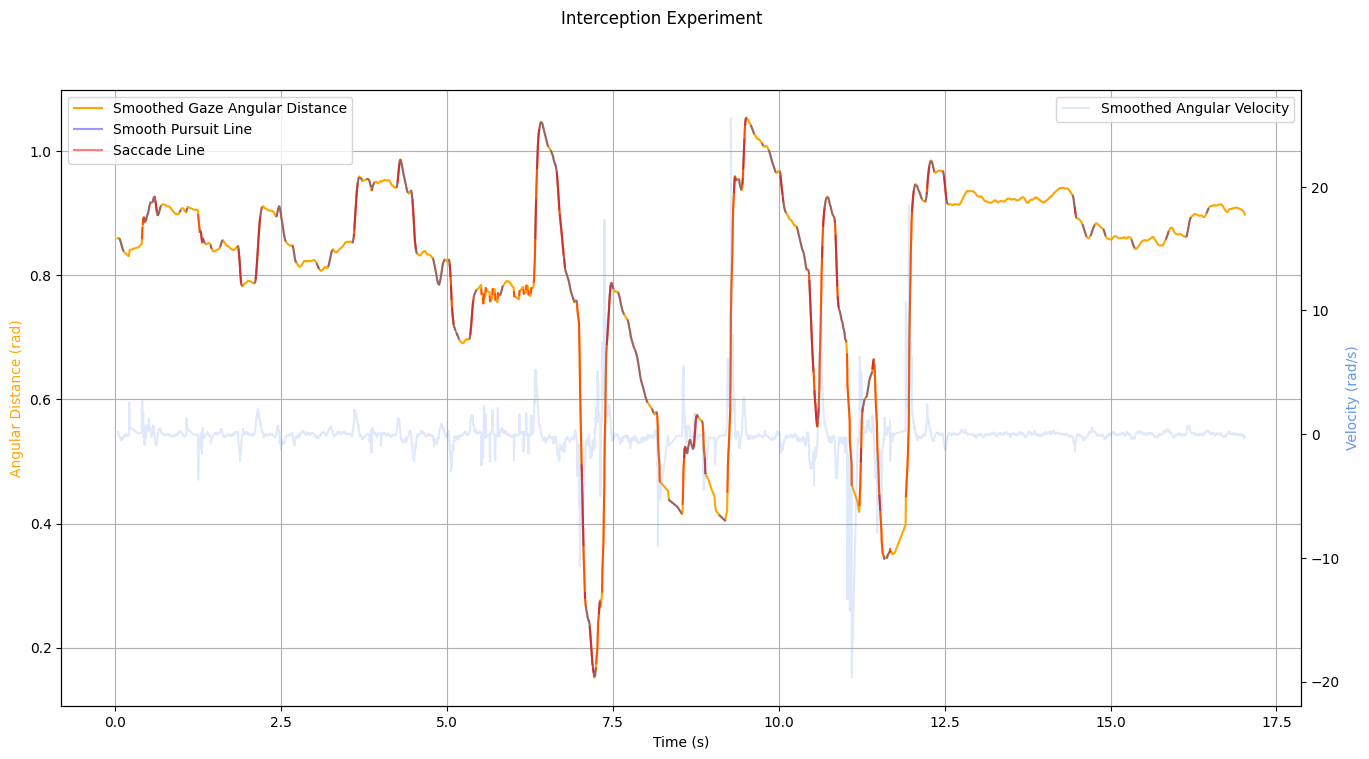

In [29]:
def plot_smooth_pursuit_graph(fig, ax, df, source='angular_velocity', velocity_tolerance=0.5, angular_distance_threshold=0.001, show_velocity=False):
    """
    Plot smooth pursuit-related data from a DataFrame against time. And optionally show the velocity graph under.

    Parameters:
        fig : The Figure object to plot on.
        ax : The primary Axes object to plot on.
        df : DataFrame containing smooth pursuit-related data.
        source (str): Source of data ('smoothed_angular_velocity' or 'smoothed_angular_distance' by default).
        velocity_tolerance (float): Tolerance for velocity changes to identify smooth pursuit.
        angular_distance_threshold (float): Threshold for identifying angular distance changes in pursuit.
        show_velocity (bool): Whether to show velocity data on the plot.
    """
    velocity_label = "Angular Velocity"
    source_angular = gaze_df['angular_distance']
    source_velocity = gaze_df['smoothed_angular_velocity']

    if (source == 'smoothed_angular_velocity'):
        source_angular = gaze_df['smoothed_angular_distance']
        source_velocity = gaze_df['smoothed_angular_velocity']
        velocity_label = "Smoothed Angular Velocity"
    else:
        source_angular = gaze_df['angular_distance']
        source_velocity = gaze_df['angular_velocity']


    # Identify periods of smooth pursuit based on velocity and angular distance
    velocity_changes = np.abs(np.gradient(source_velocity))
    angular_distance_changes = np.abs(np.gradient(source_angular))

    pursuit_regions = (velocity_changes < velocity_tolerance) & (angular_distance_changes > angular_distance_threshold)

    # Plot for Smooth Pursuit Data
    ax.plot(df['time'], np.where(pursuit_regions, source_angular, np.nan), color='blue', label='Smooth Pursuit Line', alpha=0.4)
    ax.legend(loc='upper left')

    if show_velocity:
        ax1_2 = ax.twinx()
        ax1_2.plot(df['time'], source_velocity, label=f'{velocity_label}', linestyle='-', color='cornflowerblue', alpha=0.2)
        ax1_2.set_ylabel('Velocity (rad/s)', color='cornflowerblue')
        ax1_2.legend(loc='upper right')

# Example usage for smooth pursuit
smooth_pursuit_fig, ax_smooth_pursuit = plt.subplots(figsize=(16, 8))
plot_angular_graph(smooth_pursuit_fig, ax_smooth_pursuit, gaze_df, source='smoothed_angular_distance')
plot_smooth_pursuit_graph(smooth_pursuit_fig, ax_smooth_pursuit, gaze_df, source='smoothed_angular_velocity', show_velocity=True)
plot_saccade_graph(smooth_pursuit_fig, ax_smooth_pursuit, gaze_df, source='smoothed_angular_velocity')


# Adding Annotations to the graph
To identify when the experiment occurs within the recording, as well as when object spawned and intercepted, we use the `annotations.csv` file:

`add_annotations` looks at a gieven filepath to an `annotation_csv` file and uses `labels` and `timestamp` to determine where to plot events on a Angular Distance Time Graph

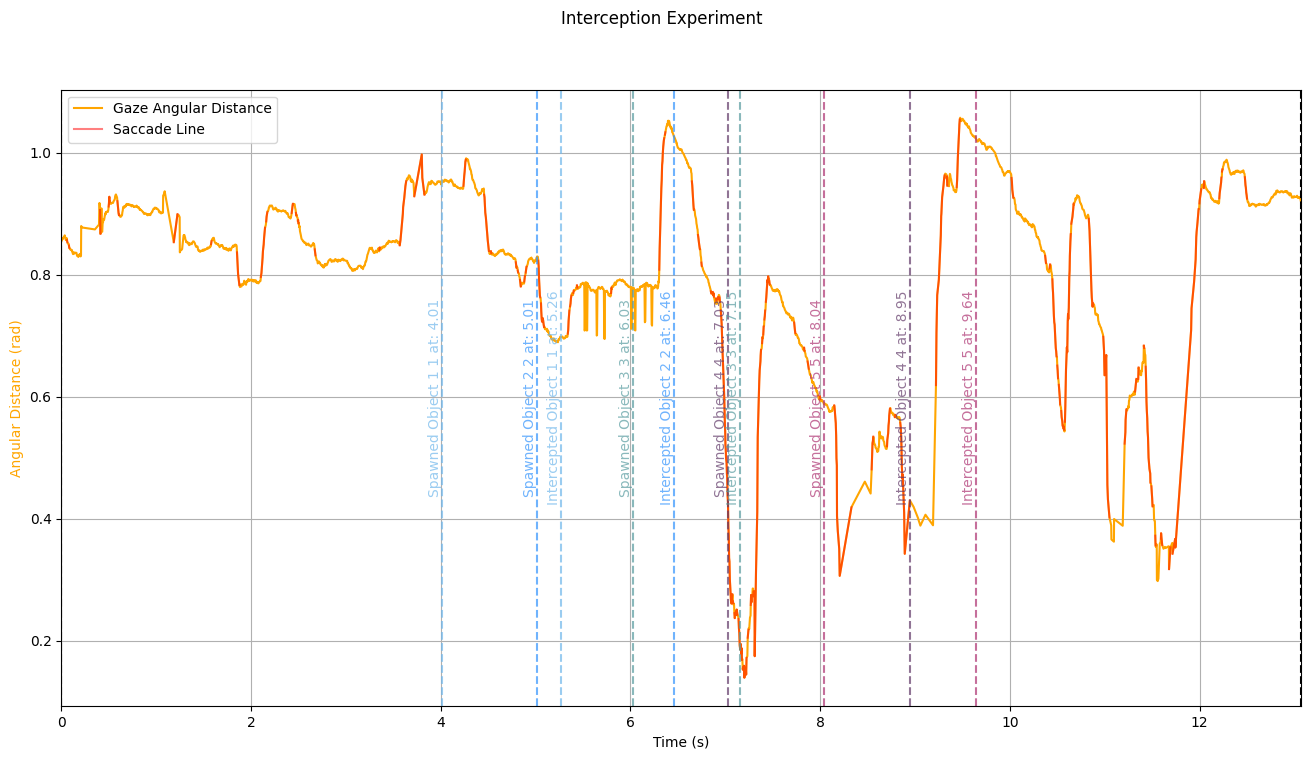

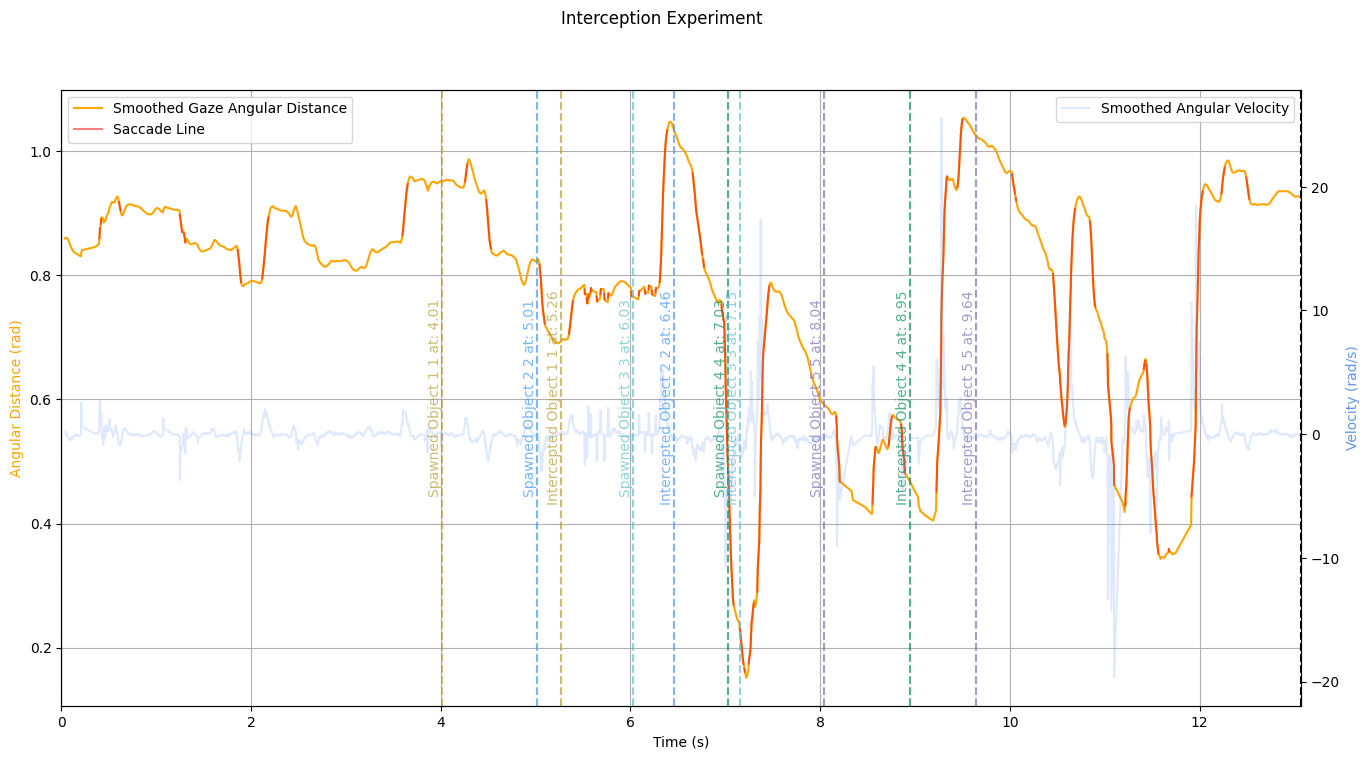

In [30]:
def add_annotations(fig, ax, filepath=None):
    """
    Add annotations to a given plot.

    Parameters:
        fig: The Figure object to add annotations to.
        ax: The Axes object to add annotations to.
        filepath (str): Path to the annotations file (CSV format).

    """
    if filepath:
        annotations_df = pd.read_csv(filepath)
        # Convert timestamps to seconds and start from 0
        annotations_df = convert_timestamps_to_time(annotations_df, 'timestamp', offset)
        
        # Identifying different types of annotation to plot on the graph
        spawn_timestamps = annotations_df.loc[annotations_df['label'].str.startswith('Spawned'), 'time'].values
        interception_timestamps = annotations_df.loc[annotations_df['label'].str.startswith('Intercepted'), 'time'].values

        start_timestamp = annotations_df.loc[(annotations_df['label'] == 'Experiment Started'), 'time'].values
        end_timestamp = annotations_df.loc[(annotations_df['label'] == 'Experiment Ended'), 'time'].values

        draw_experiment_lines(ax, start_timestamp, end_timestamp)

        object_colors = {}

        draw_objects_and_interceptions(fig, ax, spawn_timestamps, interception_timestamps, object_colors, annotations_df)

vel_ang_annotation_fig, ax = plt.subplots(figsize=(16, 8))
plot_angular_graph(vel_ang_annotation_fig, ax, gaze_df)
plot_saccade_graph(vel_ang_annotation_fig, ax, gaze_df)
add_annotations(vel_ang_annotation_fig, ax, annotations_filepath)

vel_ang_annotation_fig_smoothed, ax1 = plt.subplots(figsize=(16, 8))
plot_angular_graph(vel_ang_annotation_fig_smoothed, ax1, gaze_df, source='smoothed_angular_distance')
plot_saccade_graph(vel_ang_annotation_fig_smoothed, ax1, gaze_df, source='smoothed_angular_velocity', show_velocity=True)
add_annotations(vel_ang_annotation_fig_smoothed, ax1, annotations_filepath)

`plot_experiment` is a uniform function that will use the default paramaters to plot angular distance with identified saccades and smooth pursuit, and annotations. We can choose between smoothed or unsmoothed data, as well as display velocity.

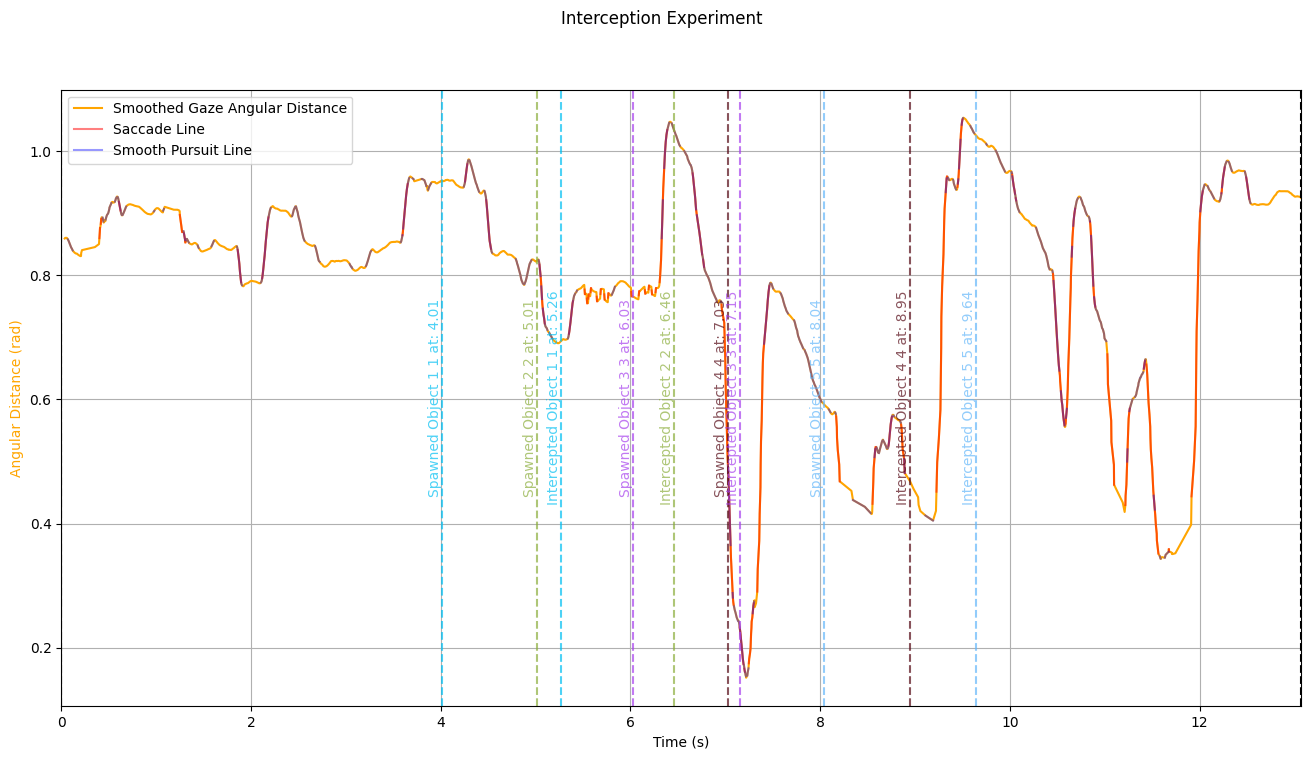

In [31]:
def plot_experiment(fig, ax, df, use_smooth=False, show_velocity=False):
    """
    Plot a combination of angular distance and saccade-related data for an experiment.

    Parameters:
        fig : The Figure object to plot on.
        ax : The primary Axes object to plot on.
        df : DataFrame containing experiment-related data.
        use_smooth (bool): Whether to use smoothed data (default is False).
        show_velocity (bool): Whether to show velocity data on the plot.
    """
    if use_smooth:
        sourceDistance = 'smoothed_angular_distance'
        sourceVelocity = 'smoothed_angular_velocity'
    else:
        sourceDistance = 'angular_distance'
        sourceVelocity = 'angular_velocity'

    plot_angular_graph(fig, ax, df, sourceDistance)
    plot_saccade_graph(fig, ax, df, sourceVelocity, show_velocity=show_velocity)
    plot_smooth_pursuit_graph(fig, ax, df, sourceVelocity)
    add_annotations(fig, ax, annotations_filepath)

experiment, exp_ax = plt.subplots(figsize=(16, 8))
plot_experiment(experiment, exp_ax, gaze_df, use_smooth=True, show_velocity=False)